In [1]:
import os
import torch
import random
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.patches as patches
from torchvision.ops import roi_align
from tqdm import tqdm
from torch.autograd import Variable
from torchvision.transforms.functional import crop as tf_crop
from difflib import SequenceMatcher
from torch.utils.data import Dataset, random_split
import torchvision
from torchvision import transforms
import einops

In [2]:
# !python3 -m venv cvproject-env
# !./cvproject-env/bin/pip install ipykernel
# !./cvproject-env/bin/python -m ipykernel install --user --name=cvproject-env --display-name "Python (cvproject-env)"


In [4]:
# !./cvproject-env/bin/pip install kagglehub
# !./cvproject-env/bin/pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !./cvproject-env/bin/pip install matplotlib
# !./cvproject-env/bin/pip install pillow tqdm einops

In [5]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("binh234/ccpd-preprocess")

print("Path to dataset files:", path)

/workspace/cvproject-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 18.5G/18.5G [03:38<00:00, 90.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/binh234/ccpd-preprocess/versions/2


In [6]:
dataset_path=path+'/CCPD2019/' #To be changed to another path if NOT training


In [7]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# The "O" means "no character".

#For the predicted characters, instead, a different list has to be used with ALL the characters available (The model doesn't
# make distinctions between the three fields of the plate)

all_characters = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "O"]
print("Number of characters:", len(all_characters))

province_to_all_idx = [all_characters.index(char) for char in provinces]
alphabet_to_all_idx = [all_characters.index(char) for char in alphabets]
ads_to_all_idx = [all_characters.index(char) for char in ads]

def decode_sequence(indices, all_characters): #The function needed to return the character sequence from the indices
    return ''.join([all_characters[i] for i in indices if i < len(all_characters)])

Number of characters: 68


In [8]:
class CCPD_Dataset(Dataset):
    def __init__(self, dataset_path, image_list, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.image_files = image_list

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path=os.path.join(self.dataset_path, img_name)
        baseimg = Image.open(img_path)
        orig_w, orig_h = baseimg.size
        if self.transform:
            image = self.transform(Image.open(img_path).convert("RGB"))
        else:
            image = Image.open(img_path).convert("RGB")
        fields = img_name.split('-')
        box_str = fields[2]
        leftup, rightbottom = box_str.split('_')
        x1, y1 = map(int, leftup.split(','))
        x2, y2 = map(int, rightbottom.split(','))

        # Target size after transform
        target_w, target_h = 300, 300

        # Scale bbox coordinates
        x1 = x1 * target_w / orig_w
        x2 = x2 * target_w / orig_w
        y1 = y1 * target_h / orig_h
        y2 = y2 * target_h / orig_h

        # Now turn the characters field into a tensor of indices (integers)
        strcharas = fields[4].split('_')
        charaslist = [int(idx) for idx in strcharas]
        provincecharidx = province_to_all_idx[charaslist[0]]
        alphabetcharidx = alphabet_to_all_idx[charaslist[1]]
        adscharidx = []
        for idx in charaslist[2:]:
            adscharidx.append(ads_to_all_idx[idx])
        charaslistdef = [provincecharidx, alphabetcharidx] + adscharidx
        
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        charas = torch.tensor([charaslistdef], dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "charas": charas
        }
        return image, target

In [9]:
# Check if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

Using device: cuda


In [10]:
def read_split_file(split_file_path):
    with open(split_file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# Paths to split files
split_dir = os.path.join(path, "CCPD2019/splits")  # adjust if needed
train_list = read_split_file(os.path.join(split_dir, "train.txt"))
val_list = read_split_file(os.path.join(split_dir, "val.txt"))
test_list = read_split_file(os.path.join(split_dir, "test.txt"))
# The augmented version
E2E_transform = transforms.Compose([
    transforms.Resize((340, 340)),
    transforms.RandomRotation(degrees=random.randint(0, 15)),
    transforms.CenterCrop((300, 300)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# The base version
no_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# This selects one of the two transformations at random for each image.
class RandomTransformSelector:
    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, img):
        transform = random.choice(self.transforms_list)
        return transform(img)

random_transform = RandomTransformSelector([E2E_transform, no_transform])
train_dataset = CCPD_Dataset(dataset_path, train_list, transform=random_transform)
val_dataset = CCPD_Dataset(dataset_path, val_list, transform=no_transform)
test_dataset = CCPD_Dataset(dataset_path, test_list, transform=no_transform)

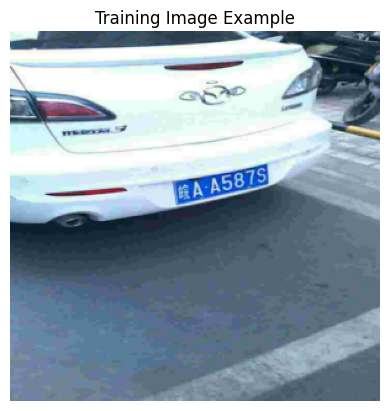

In [11]:
# Train dataset example
image, target = train_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize

image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Training Image Example")
plt.show()

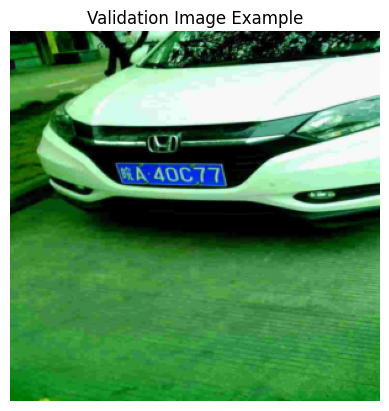

In [12]:
# Train dataset example
image, target = val_dataset[random.randint(0, len(train_dataset)-1)]
image = image * 0.5 + 0.5  # Unnormalize
image = image.clamp(0, 1)  # Clamp to [0, 1] range
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Validation Image Example")
plt.show()

In [13]:
def collate_dicttargets(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

### 2nd Baseline: Customized FastRCNN + (CNN+LSTM Recognition Model)
##### FastRCNN model has been used in detection and could classify and refine bounding boxes (for license plates) in images. This custom model which is used for training consists of the architecture of CNN backbone network (here Resnet34 network is used for its simple architecture) which mainly extracts important features from image to create a feature map. This model directly uses ground-truth boxes as input proposals to be readjusted. These proposals are aligned with the feature maps using roi_align to extract fixed-size region features.

##### Final output of this class are class logits which represent classification scores for region, proposals and bbox predictions which refine the coordinates of the input boxes. This class also contains inference block (when the model is not in training mode) to convert the raw output logits into meaningful predictions. Main function is to select the highest probability (as the detection score) and its class label for each predicted region. These results are added to the models output dictionary under "scores" and "labels" to make it easier to interpret and evaluate predictions during validation.

In [14]:
class FastRCNN(nn.Module):
  def __init__(self, num_classes=2):
    super(FastRCNN, self).__init__()
    self.num_classes=num_classes
    model_base = torchvision.models.resnet34(pretrained=True)
    self.base=nn.Sequential(*(list(model_base.children())[:-2]))
    self.shared_conv = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU(inplace=True)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(256, 256)
    self.dropout = nn.Dropout(0.5)
    self.classifier = nn.Linear(256, num_classes)
    self.bbox_pred = nn.Linear(256, num_classes * 4)

  def forward(self, x,proposals):
    features = self.base(x)
    features2 = self.shared_conv(features)
    shared_features = self.relu(features2)
    features_pooled=roi_align(shared_features, proposals, output_size=(7, 7),
                           spatial_scale=1.0 / 32.0, sampling_ratio=2, aligned=True)
    x = self.avgpool(features_pooled)
    x = torch.flatten(x,1)
    x = self.fc(x)
    x = self.dropout(x)
    x=  self.relu(x)
    class_logits = self.classifier(x)
    bbox_pred = self.bbox_pred(x)
    output = {
        "class_logits": class_logits,
        "bbox_pred": bbox_pred,
        "boxes": proposals
    }
    if not self.training:
        probs = torch.softmax(class_logits, dim=-1)
        scores, labels = probs.max(dim=-1)
        output["scores"] = scores
        output["labels"] = labels

    return output

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline2 = FastRCNN(num_classes=2).to(device)

print(baseline2)


/workspace/cvproject-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/cvproject-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 115MB/s] 


FastRCNN(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

#### This loss function uses the classification and bounding box regression errors to calculate the loss required to train customized Fast R-CNN model. Its inputs are the ground truth (targets) and the model's predictions (class_logits and bbox_pred). The classification loss, which checks how well the predicted class scores match the true labels, is calculated using CrossEntropyLoss when the true class labels and bounding boxes are extracted from the targets. The predicted bounding boxes are then reshaped to assign each to a class, and only those that match the ground-truth labels are chosen. SmoothL1Loss is used to compute the bounding box regression loss, penalising differences between the real and predicted box coordinates. 

In [16]:
def FastRCNN_losses(preds,targets):
  CEL=nn.CrossEntropyLoss()
  L1=nn.SmoothL1Loss()
  labels=torch.cat([target['labels'] for target in targets])
  bbox=torch.cat([target['boxes'] for target in targets])
  class_logits=preds["class_logits"]
  bbox_pred=preds["bbox_pred"]
  class_loss=CEL(class_logits,labels)
  N=bbox_pred.size(0)
  num_classes=2
  bbox_pred = bbox_pred.view(N, num_classes, 4)
  bbox_pred = bbox_pred[torch.arange(N), labels]
  L1 = nn.SmoothL1Loss()
  bbox_loss = L1(bbox_pred, bbox)
  return {
        "Class_loss": class_loss,
        "bbox_loss": bbox_loss
    }


#### Training the customized FastRCNN

In [17]:
batch_size = 10
num_epochs = 3
learning_rate = 0.01
optimizer = torch.optim.Adam(baseline2.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dicttargets, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dicttargets)

In [ ]:
# for epoch in range(num_epochs):
#     baseline2.train()
#     running_loss = 0.0
#     for batch_idx, (images, targets) in enumerate(train_loader):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         proposals = [t["boxes"] for t in targets]  
#         optimizer.zero_grad()
#         images_tensor = torch.stack(images, dim=0)  
#         predictions = baseline2(images_tensor, proposals)
#         loss_dict = FastRCNN_losses(predictions, targets)
#         loss = sum(loss for loss in loss_dict.values())
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         if batch_idx % 10 == 0:
#             print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

#     print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {running_loss/len(train_loader):.4f}")

#### Saving the weights of the model for recognition

In [19]:
#torch.save(baseline2.state_dict(), "fast_rcnn_weights.pth")

In [20]:
baseline2.load_state_dict(torch.load('fast_rcnn_weights.pth', weights_only=True))

<All keys matched successfully>

In [21]:
def show_bounding_box(image, boxes, scores=None, top_k=None):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5).clip(0, 1)
    plt.imshow(image)
    cmap = plt.colormaps.get_cmap('plasma')    
    if scores is not None:
        if top_k is not None:
            indices = np.argsort(scores)[-top_k:]
            boxes = boxes[indices]
            scores = scores[indices]
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)  # Normalize to [0,1]
        colors = cmap(norm_scores)
        
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        color = colors[i][:3] if scores is not None else 'red'
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2))

    if scores is not None and len(scores) > 0:
        norm = mpl.colors.Normalize(vmin=scores.min(), vmax=scores.max())
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
        cbar.set_label('Confidence Score') 
           
    plt.suptitle(f'Predicted Bounding Boxes (Showing best {len(boxes)} boxes)')   
    plt.axis('off')
    plt.show()

#### Validation Loop of model

In [22]:
# baseline2.eval()
# val_loss = 0.0

# with torch.no_grad():
#     for batch_idx, (images, targets) in enumerate(val_loader):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         proposals = [t["boxes"] for t in targets]  
#         images_tensor = torch.stack(images, dim=0)  
#         predictions = baseline2(images_tensor, proposals)
#         loss_dict = FastRCNN_losses(predictions, targets)
#         loss = sum(loss for loss in loss_dict.values())
#         val_loss += loss.item()
#         if batch_idx % 10 == 0:
#             print(f"[Val] Batch {batch_idx}/{len(val_loader)}, Loss: {loss.item():.4f}")

# avg_val_loss = val_loss / len(val_loader)
# print(f"Average Validation Loss: {avg_val_loss:.4f}")

##### Sample validation image

Predicted classes: [1]
Predicted bounding boxes: [[ -0.29577425   0.38900018  -0.5222042   -0.3059468 ]
 [ 74.39171    133.20172    181.6205     156.08072   ]]


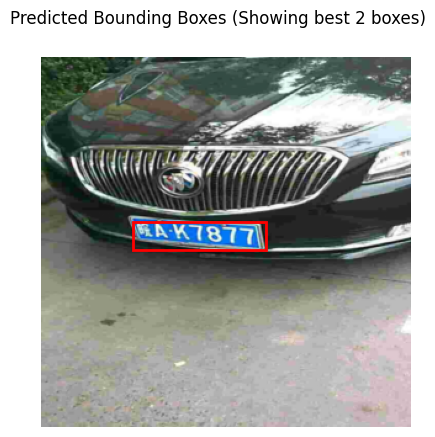

In [40]:
baseline2.eval()
with torch.no_grad():
    image, target = train_dataset[random.randint(0, len(train_dataset)-1)]
    image = image.unsqueeze(0).to(device)
    proposals = target["boxes"].to(device).unsqueeze(0)  
    outputs = baseline2(image[0].unsqueeze(0), [proposals[0]])
    class_logits = outputs["class_logits"]
    bbox_pred = outputs["bbox_pred"]
    pred_class = class_logits.argmax(dim=1).cpu().numpy()
    pred_boxes = bbox_pred.cpu().numpy().reshape(-1, 4)
    print("Predicted classes:", pred_class)
    print("Predicted bounding boxes:", pred_boxes)
    show_bounding_box(image[0], pred_boxes, scores=None, top_k=None)

### Recognition Model (CNN+LSTM)
#### Recognition model that is used fit well with detection model , is a customized model which consists of convulution layers of CNN and LSTM (Rnn architecture). The CNN part first extracts spatial features from the input plate image through convolution, normalization, activation, and pooling layers. These features are then reshaped and passed into a bidirectional LSTM which captures sequential dependencies across the width of the plate, useful for reading characters in order. The output from the LSTM is passed through a fully connected layer to produce logits for each character position, including an extra class for the CTC blank token used during training.

###### References: https://link.springer.com/chapter/10.1007/978-981-15-0121-0_52, https://arxiv.org/abs/1701.06439.

In [24]:
class PlateRecognitionModel(nn.Module):
    def __init__(self, num_classes=len(all_characters)):
        super(PlateRecognitionModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
        )
        self.rnn = nn.LSTM(input_size=128*8, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256 * 2, num_classes + 1)  

    def forward(self, x): 
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous().view(b, w, -1)  
        x, _ = self.rnn(x) 
        x = self.fc(x)  
        x = x.permute(1, 0, 2) 
        return x

#### This function extract_plate_regions crops detected plate regions from the input images based on bounding boxes and resizes them to a fixed size, ensuring uniform input to the recognition model.

In [25]:
def extract_plate_regions(images, detections, output_size=(32, 128)):
    cropped_plates = []
    for i, img in enumerate(images):
        box_tensor = detections["boxes"][i]  # shape: [1, 4]
        box = box_tensor[0].detach().cpu().numpy().astype(int)  # Extract single box
        x1, y1, x2, y2 = box
        _, h, w = img.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        cropped = transforms.functional.crop(img.cpu(), y1, x1, y2 - y1, x2 - x1)
        cropped = transforms.Resize(output_size)(cropped)
        cropped_plates.append(cropped)
    return torch.stack(cropped_plates) 

In [26]:
ctc_loss_fn = nn.CTCLoss(blank=len(all_characters), zero_infinity=True)

#### Training recognition model with FastRCNN weights

In [31]:
recognition_model = PlateRecognitionModel().to(device)
recognition_optimizer = torch.optim.Adam(recognition_model.parameters(), lr=0.001)
print(recognition_model)
# for epoch in range(3):
#     baseline2.eval()
#     recognition_model.train()
    
#     for batch_idx, (images, targets) in enumerate(train_loader):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         proposals = [t["boxes"] for t in targets]

#         with torch.no_grad():  # Don't train detector
#             images_tensor = torch.stack(images, dim=0)
#             detections = baseline2(images_tensor, proposals)
#         plate_images = extract_plate_regions(images_tensor, detections).to(device)  # [B, 3, 32, 128]

#         # Step 2: Prepare targets for recognition
#         text_targets = torch.cat([t["charas"] for t in targets])  # [B, 7]
#         input_lengths = torch.full(size=(plate_images.size(0),), fill_value=plate_images.size(-1) // 4, dtype=torch.long).to(device)
#         target_lengths = torch.full(size=(plate_images.size(0),), fill_value=7, dtype=torch.long).to(device)

#         # Step 3: Forward pass
#         preds = recognition_model(plate_images)  # [T, B, C]
#         loss = ctc_loss_fn(preds, text_targets.view(-1), input_lengths, target_lengths)

#         # Step 4: Optimize
#         recognition_optimizer.zero_grad()
#         loss.backward()
#         recognition_optimizer.step()

#         if batch_idx % 10 == 0:
#             print(f"[Epoch {epoch+1}] Batch {batch_idx}, Recognition Loss: {loss.item():.4f}")

PlateRecognitionModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(1024, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=69, bias=True)
)


In [32]:
# torch.save({
#     'model_state_dict': recognition_model.state_dict(),
#     'optimizer_state_dict': recognition_optimizer.state_dict(),
#     'epoch': epoch,
# }, 'recognition_model_checkpoint.pth')

In [33]:
checkpoint = torch.load('recognition_model.pth')
recognition_model.load_state_dict(checkpoint['model_state_dict'])
recognition_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

### Implementation of metric functions to evaluate performance of character sequence prediction model. 
##### 1) The levenshtein_ratio function computes the similarity between two strings based on character-level edits using the Levenshtein distance.
##### 2) The calculate_metrics function compares predicted and target sequences (converted to strings using decode_sequence) and calculates three key metrics: character accuracy (percentage of correctly predicted characters across all samples), exact match accuracy (how many full sequences match exactly), and average Levenshtein similarity (average similarity score between predicted and target texts).
##### 3) The decode_sequence_ctc function decodes the models output by collapsing repeated characters and removing blank indices, as in CTC-based function.
###### References: https://arxiv.org/abs/2203.14298 , https://link.springer.com/article/10.1007/s11042-012-1199-5 

In [34]:
def levenshtein_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

def calculate_metrics(preds, targets, all_characters):
    total_chars = 0
    correct_chars = 0
    total_samples = len(preds)
    exact_matches = 0
    lev_ratios = []
    for pred_seq, target_seq in zip(preds, targets):
        pred_text = decode_sequence(pred_seq, all_characters)
        target_text = decode_sequence(target_seq, all_characters)
        total_chars += len(target_text)
        correct_chars += sum(p == t for p, t in zip(pred_text, target_text))
        if pred_text == target_text:
            exact_matches += 1
        lev_ratios.append(levenshtein_ratio(pred_text, target_text))
    char_accuracy = correct_chars / total_chars
    exact_match_accuracy = exact_matches / total_samples
    avg_levenshtein = sum(lev_ratios) / len(lev_ratios)
    return {
        "char_accuracy": char_accuracy,
        "plate_accuracy": exact_match_accuracy,
        "avg_levenshtein_ratio": avg_levenshtein
    }

In [35]:
def decode_sequence_ctc(indices, all_characters, blank_index=None):
    decoded = []
    prev_idx = -1
    for idx in indices:
        if idx != prev_idx and idx != blank_index:
            if idx < len(all_characters):
                decoded.append(all_characters[idx])
        prev_idx = idx
    return ''.join(decoded)
def per_sample_char_accuracy(pred, target):
    return sum(p == t for p, t in zip(pred, target)) / max(len(target), 1)

#### Evaluation of recognition model


 Sample Image 1
GT : 皖AV70L
Predicted: 皖AV700L
Char Accuracy: 83.33%
Levenshtein Similarity: 92.31%


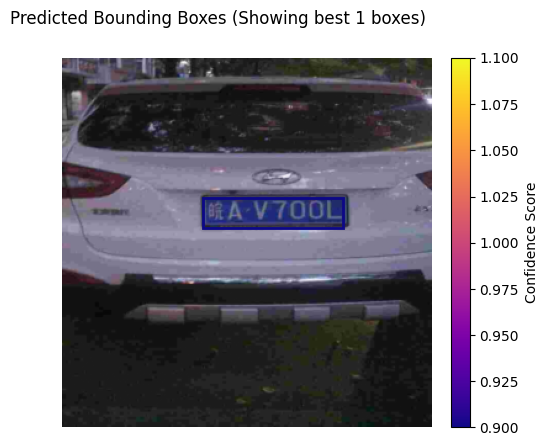


 Sample Image 2
GT : 皖AC8278
Predicted: 皖AC8278
Char Accuracy: 100.00%
Levenshtein Similarity: 100.00%


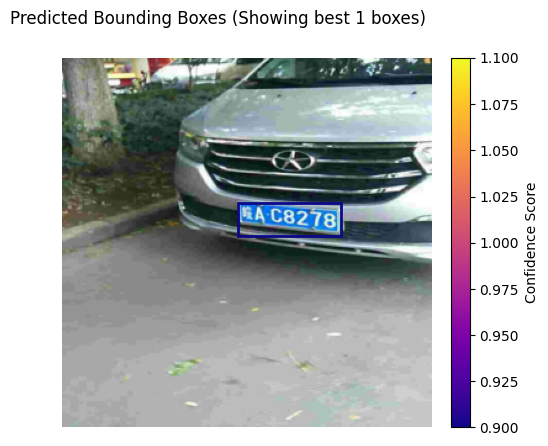


 Sample Image 3
GT : 皖AZ1Z8
Predicted: 皖AZ1Z88
Char Accuracy: 100.00%
Levenshtein Similarity: 92.31%


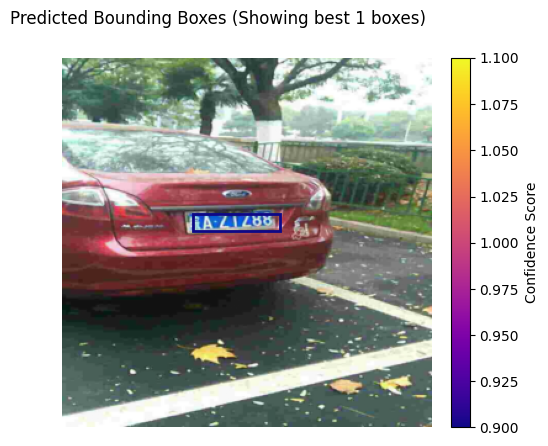


 Sample Image 4
GT : 皖A50D60
Predicted: 皖A50D60
Char Accuracy: 100.00%
Levenshtein Similarity: 100.00%


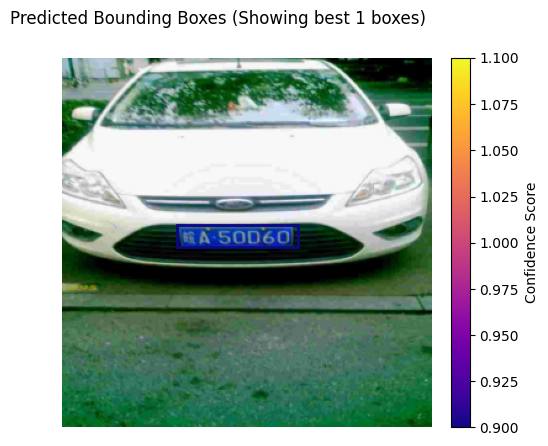


 Sample Image 5
GT : 皖AT19H
Predicted: 皖AT199H
Char Accuracy: 83.33%
Levenshtein Similarity: 92.31%


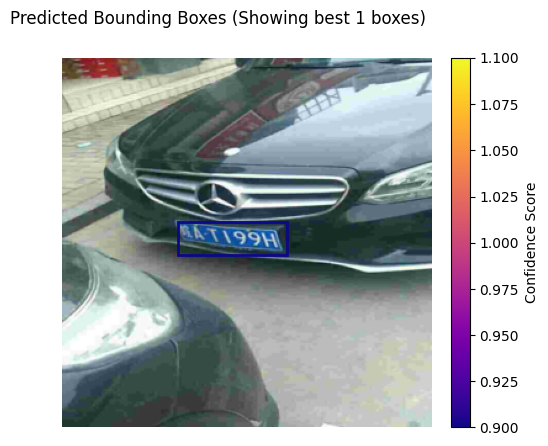


 Sample Image 6
GT : 皖AJE97
Predicted: 皖AJE997
Char Accuracy: 83.33%
Levenshtein Similarity: 92.31%


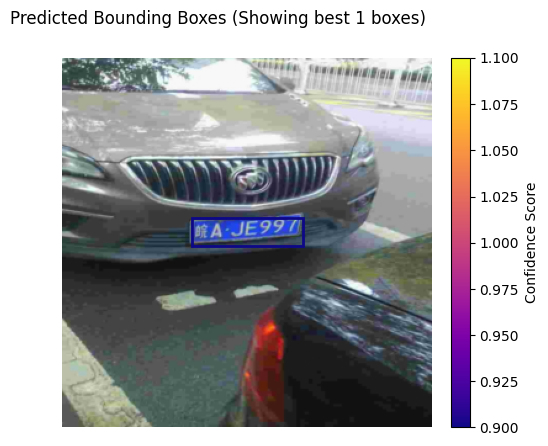

In [ ]:
recognition_model.eval()
all_preds = []
all_targets = []
blank_idx = all_characters.index("O") 

shown_samples = 0
max_samples = 6
with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(val_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        proposals = [t["boxes"] for t in targets]
        images_tensor = torch.stack(images)
        detections = baseline2(images_tensor, proposals)
        plate_images = extract_plate_regions(images_tensor, detections).to(device)
        preds = recognition_model(plate_images)  
        pred_indices = preds.argmax(dim=-1).permute(1, 0).tolist()  
        gt_indices = [t["charas"][0].tolist() for t in targets]     
        all_preds.extend(pred_indices)
        all_targets.extend(gt_indices)
        
for i in range(len(images)):
    if shown_samples >= max_samples:
        break

    pred_text = decode_sequence_ctc(pred_indices[i], all_characters, blank_index=blank_idx)
    gt_text = decode_sequence_ctc(gt_indices[i], all_characters, blank_index=blank_idx)
    char_acc = per_sample_char_accuracy(pred_text, gt_text)
    lev_sim = levenshtein_ratio(pred_text, gt_text)

    print(f"\n Sample Image {shown_samples+1}")
    print(f"GT : {gt_text}")
    print(f"Predicted: {pred_text}")
    print(f"Char Accuracy: {char_acc:.2%}")
    print(f"Levenshtein Similarity: {lev_sim:.2%}")

    #Visualization
    image = images_tensor[i].cpu()
    boxes = detections["boxes"][i].detach().cpu()
    scores = detections["scores"][i].detach().cpu()

    if boxes.numel() > 0:
        #  detection
        if boxes.ndim == 1:
            boxes = boxes[None, :]
        if np.isscalar(scores) or scores.ndim == 0:
            scores = np.array([scores])
        else:
            scores = scores.numpy()

        boxes = boxes.numpy()

        show_bounding_box(image, boxes=boxes, scores=scores, top_k=1)

    shown_samples += 1 

In [37]:
metrics = calculate_metrics(all_preds, all_targets, all_characters)
print("\n Final Metrics over validation set:")
print(f"Character Accuracy: {metrics['char_accuracy']:.5f}")
print(f"Plate Accuracy (Exact Match): {metrics['plate_accuracy']:.5f}")
print(f"Avg Levenshtein Ratio: {metrics['avg_levenshtein_ratio']:.5f}")


 Final Metrics over validation set:
Character Accuracy: 0.95521
Plate Accuracy (Exact Match): 0.85054
Avg Levenshtein Ratio: 0.98601
